# 题目4—路况预测
## 题目简述
问题简述：回归问题。根据提供的路口位置、行驶方向、时间等信息对路口建模，预测特定时间下某个路口的路况。具体来说，需要预测车辆静止总时长和路口排队长度的20%、50% 和 80% 分位数，共 6 项指标。

评价方式：6项指标均方误差（MSE）的平均值

## 用到的库
python: 3.9.21

In [ ]:
!pip install pandas==2.2.3
!pip install numpy==2.0.2
!pip install lightgbm==4.6.0
!pip install bayesian-optimization==3.0.0
!pip install scikit-learn==1.6.1
!pip install matplotlib==3.9.4
!pip install seaborn==0.13.2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

## 读取数据

In [328]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

了解数据结构

In [329]:
# Display the description of the train and test dataframes
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

display(description(train_df))
display(description(test_df))

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int64,0,500000,0,1,2
1,IntersectionId,int64,0,2545,238,1776,929
2,Latitude,float64,0,4767,41.864774,39.957401,39.945331
3,Longitude,float64,0,4772,-87.685926,-75.157071,-75.241781
4,EntryStreetName,object,4793,1680,West Ogden Avenue,North 11th Street,Baltimore Avenue
5,ExitStreetName,object,3684,1654,South Western Avenue,Vine Street,Baltimore Avenue
6,EntryHeading,object,0,8,S,N,W
7,ExitHeading,object,0,8,S,W,W
8,Hour,int64,0,24,13,17,14
9,Weekend,int64,0,2,0,0,1


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int64,0,100000,500000,500001,500002
1,IntersectionId,int64,0,2475,704,352,397
2,Latitude,float64,0,4562,39.955573,42.298238,33.820597
3,Longitude,float64,0,4567,-75.180482,-71.057048,-84.451133
4,EntryStreetName,object,908,1497,John F. Kennedy Boulevard,Gibson Street,Bolton Road
5,ExitStreetName,object,710,1469,John F. Kennedy Boulevard,Adams Street,Bolton Road
6,EntryHeading,object,0,8,W,E,E
7,ExitHeading,object,0,8,N,NW,E
8,Hour,int64,0,24,0,9,18
9,Weekend,int64,0,2,0,0,0


In [330]:
# 查找不同城市中相同 IntersectionId 的路口
dup = train_df.groupby('IntersectionId')['City'].nunique().reset_index()
dup = dup[dup['City'] > 1]
result = train_df[train_df['IntersectionId'].isin(dup['IntersectionId'])]
display(result[['IntersectionId', 'City']].drop_duplicates().sort_values('IntersectionId'))

,IntersectionId,City
4141,0,Boston
7851,0,Philadelphia
4038,0,Atlanta
41136,0,Chicago
1791,1,Atlanta
...,...,...
257,1983,Philadelphia
21570,1988,Philadelphia
7819,1988,Chicago
10450,1989,Philadelphia


归纳数据特征
- id：数据编号，每条记录的唯一标识。
- IntersectionId：路口编号，每个城市中的交叉路口有唯一ID，不同城市可能有相同的路口编号。
- Latitude：路口的地理纬度坐标。
- Longitude：路口的地理经度坐标。
- EntryStreetName：进入路口的街道名称。
- ExitStreetName：驶出路口的街道名称。
- EntryHeading：进入路口时车辆的朝向（如N、S、E、W等）。
- ExitHeading：驶出路口时车辆的朝向。
- Hour：小时，表示事件发生的小时（0-23）。
- Weekend：是否为周末，0表示工作日，1表示周末。
- Month：月份，表示事件发生的月份（1-12）。
- Path：路径信息，通常由进入和驶出街道及方向拼接而成。
- TotalTimeStopped_p20/p40/p50/p60/p80：车辆在路口停止的总时间的不同分位数（20%、40%、50%、60%、80%）。
- TimeFromFirstStop_p20/p40/p50/p60/p80：车辆从第一次停止到完全通过路口所用时间的不同分位数。
- DistanceToFirstStop_p20/p40/p50/p60/p80：车辆到达第一个停止点的距离的不同分位数。
- City：城市名称，数据涉及的城市有Chicago、Philadelphia等。

## 解题方案
由于不同城市可能有相同的路口编号，我们拼接 `IntersectionId` 和 `City` 两列作为唯一路口标识

In [331]:
# Create a new column 'Intersection' by combining 'IntersectionId' and 'City'
train_df['Intersection'] = train_df['IntersectionId'].astype(str) + train_df['City']
test_df['Intersection'] = test_df['IntersectionId'].astype(str) + test_df['City']
print(train_df['Intersection'].sample(6).values)

# Encode the 'Intersection' column using LabelEncoder
le = LabelEncoder()
le.fit(pd.concat([train_df['Intersection'], test_df['Intersection']]).drop_duplicates().values)
train_df['Intersection'] = le.transform(train_df['Intersection'])
test_df['Intersection'] = le.transform(test_df['Intersection'])
print(train_df['Intersection'].sample(6).values)

['508Atlanta' '196Philadelphia' '371Chicago' '1430Philadelphia'
 '157Philadelphia' '830Philadelphia']
[ 418 1543 2595 1939  242 3703]


对道路类型进行编码

In [332]:
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

def encode(x):
    if pd.isna(x): # NaN values
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
        
    return 0

train_df['EntryTypeStreet'] = train_df['EntryStreetName'].apply(encode)
train_df['ExitTypeStreet'] = train_df['ExitStreetName'].apply(encode)
test_df['EntryTypeStreet'] = test_df['EntryStreetName'].apply(encode)
test_df['ExitTypeStreent'] = test_df['ExitStreetName'].apply(encode)
print(train_df['EntryTypeStreet'].sample(10).values)

[2 2 2 2 2 2 2 3 1 2]


判断车辆进入和驶出路口时是否是同一条街道。如果是，则赋值为 1，否则为 0。这一特征可以反映车辆是否在路口掉头或原路返回等特殊行为，对路口拥堵和通行情况有一定的指示作用。

In [333]:
train_df["same_street_exact"] = (train_df["EntryStreetName"] ==  train_df["ExitStreetName"]).astype(int)
test_df["same_street_exact"] = (test_df["EntryStreetName"] ==  test_df["ExitStreetName"]).astype(int)
print(train_df['same_street_exact'].sample(10).values)

[0 1 0 1 0 1 0 1 1 1]


对车头朝向进行编码

In [334]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

train_df['EntryHeading'] = train_df['EntryHeading'].map(directions)
train_df['ExitHeading'] = train_df['ExitHeading'].map(directions)
test_df['EntryHeading'] = test_df['EntryHeading'].map(directions)
test_df['ExitHeading'] = test_df['ExitHeading'].map(directions)

判断车头朝向是否改变

In [335]:
train_df['diffHeading'] = train_df['EntryHeading']- train_df['ExitHeading']  
test_df['diffHeading'] = test_df['EntryHeading']- test_df['ExitHeading']

display(train_df[['ExitHeading','EntryHeading','diffHeading']].drop_duplicates().head(5))

,ExitHeading,EntryHeading,diffHeading
0,1.00,1.00,0.0
1,1.50,0.00,-1.5
2,1.50,1.50,0.0
6,1.25,1.25,0.0
8,0.00,0.00,0.0


把原始的线性数值（如小时 0~23）映射到单位圆上的点，使得 0 点和 23 点在空间上也是相邻的。这样，模型就能更好地捕捉到时间的周期性规律，提高预测效果。

In [336]:
def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

train_df = cyclical_encode(train_df, 'Hour', 24)
test_df = cyclical_encode(test_df, 'Hour', 24) 

将原本的类别型变量（月份）转化为模型更容易理解的数值型变量，避免模型误认为月份之间有大小关系。
- `pd.get_dummies(train_df['Month'], prefix='Month', drop_first = False)` 会把 Month 这一列的每个取值（如1月、2月、…、12月）都变成一个新的二进制列，每一列代表某个月份，属于该月则为1，否则为0。
- `pd.concat([...], axis=1)` 把这些新生成的列拼接回原始数据框。

In [337]:
'''One Hot Ecoding of month feature'''
train_df = pd.concat([train_df, pd.get_dummies(train_df['Month'], prefix='Month', drop_first = False)], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Month'], prefix='Month', drop_first = False)], axis=1)
print(train_df.filter(like='Month').sample(10).values)

[[6 False False True False False False False False False]
 [11 False False False False False False False True False]
 [12 False False False False False False False False True]
 [9 False False False False False True False False False]
 [10 False False False False False False True False False]
 [12 False False False False False False False False True]
 [11 False False False False False False False True False]
 [12 False False False False False False False False True]
 [6 False False True False False False False False False]
 [9 False False False False False True False False False]]


这样做的目的是将原本的类别型变量（城市）转化为模型更容易理解的数值型变量，避免模型误认为城市之间有大小关系。

In [338]:
'''One Hot Ecoding of City feature'''
train_df = pd.concat([train_df, pd.get_dummies(train_df['City'], drop_first = False)], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['City'], drop_first = False)], axis=1)

温度信息并未直接给出，跳过这部分

In [339]:
# """Adding temperature (°F) of each city by month"""
# monthly_avg = {'Atlanta1': 43.0, 'Atlanta5': 68.5, 'Atlanta6': 76.0, 'Atlanta7': 78.0, 'Atlanta8': 78.0, 'Atlanta9': 72.5,
#               'Atlanta10': 62.0, 'Atlanta11': 52.5, 'Atlanta12': 45.0, 'Boston1': 29.5, 'Boston5': 58.5, 'Boston6': 68.0,
#               'Boston7': 74.0, 'Boston8': 73.0, 'Boston9': 65.5, 'Boston10': 54.5,'Boston11': 45.0, 'Boston12': 35.0,
#               'Chicago1': 27.0, 'Chicago5': 59.5, 'Chicago6': 70.0, 'Chicago7': 76.0, 'Chicago8': 75.5, 'Chicago9': 68.0,
#               'Chicago10': 56.0,  'Chicago11': 44.5, 'Chicago12': 32.0, 'Philadelphia1': 34.5, 'Philadelphia5': 66.0,
#               'Philadelphia6': 75.5, 'Philadelphia7': 80.5, 'Philadelphia8': 78.5, 'Philadelphia9': 71.5, 'Philadelphia10': 59.5,
#               'Philadelphia11': 49.0, 'Philadelphia12': 40.0}

# train_df['city_month'] = train_df["City"] + train_df["Month"].astype(str)
# test_df['city_month'] = test_df["City"] + test_df["Month"].astype(str)

# # Creating a new column by mapping the city_month variable to it's corresponding average monthly temperature
# train_df["average_temp"] = train_df['city_month'].map(monthly_avg)
# test_df["average_temp"] = test_df['city_month'].map(monthly_avg)

In [340]:
# """Adding rainfall (inches) of each city by month"""
# monthly_rainfall = {'Atlanta1': 5.02, 'Atlanta5': 3.95, 'Atlanta6': 3.63, 'Atlanta7': 5.12, 'Atlanta8': 3.67, 'Atlanta9': 4.09,
#               'Atlanta10': 3.11, 'Atlanta11': 4.10, 'Atlanta12': 3.82, 'Boston1': 3.92, 'Boston5': 3.24, 'Boston6': 3.22,
#               'Boston7': 3.06, 'Boston8': 3.37, 'Boston9': 3.47, 'Boston10': 3.79,'Boston11': 3.98, 'Boston12': 3.73,
#               'Chicago1': 1.75, 'Chicago5': 3.38, 'Chicago6': 3.63, 'Chicago7': 3.51, 'Chicago8': 4.62, 'Chicago9': 3.27,
#               'Chicago10': 2.71,  'Chicago11': 3.01, 'Chicago12': 2.43, 'Philadelphia1': 3.52, 'Philadelphia5': 3.88,
#               'Philadelphia6': 3.29, 'Philadelphia7': 4.39, 'Philadelphia8': 3.82, 'Philadelphia9':3.88 , 'Philadelphia10': 2.75,
#               'Philadelphia11': 3.16, 'Philadelphia12': 3.31}
# # Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
# train_df["average_rainfall"] = train_df['city_month'].map(monthly_rainfall)
# test_df["average_rainfall"] = test_df['city_month'].map(monthly_rainfall)

对“Latitude”（纬度）和“Longitude”（经度）这两个地理位置特征进行标准化处理，使它们具有均值为0、方差为1的分布。消除不同特征之间的量纲影响，让模型更容易收敛并提升预测效果。

In [341]:
scaler = StandardScaler()
train_df['Latitude'] = (scaler.fit_transform(train_df['Latitude'].values.reshape(-1, 1)))
train_df['Longitude'] = (scaler.fit_transform(train_df['Longitude'].values.reshape(-1, 1)))
test_df['Latitude'] = (scaler.fit_transform(test_df['Latitude'].values.reshape(-1, 1)))
test_df['Longitude'] = (scaler.fit_transform(test_df['Longitude'].values.reshape(-1, 1)))

In [342]:
"""Let's see the columns of data"""
train_df.columns.values

array(['id', 'IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Path', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60',
       'TotalTimeStopped_p80', 'TimeFromFirstStop_p20',
       'TimeFromFirstStop_p40', 'TimeFromFirstStop_p50',
       'TimeFromFirstStop_p60', 'TimeFromFirstStop_p80',
       'DistanceToFirstStop_p20', 'DistanceToFirstStop_p40',
       'DistanceToFirstStop_p50', 'DistanceToFirstStop_p60',
       'DistanceToFirstStop_p80', 'City', 'Intersection',
       'EntryTypeStreet', 'ExitTypeStreet', 'same_street_exact',
       'diffHeading', 'Hour_sin', 'Hour_cos', 'Month_1', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Atlanta', 'Boston', 'Chicago', 'Philadelphia'],
      dtype=object)

In [343]:
"""Let's drop the unwanted variables from test and train dataset"""
train_df.drop(['id', 'IntersectionId', 'EntryStreetName', 'ExitStreetName', 'Path', 'City'], axis=1, inplace=True)
test_df.drop(['id', 'IntersectionId', 'EntryStreetName', 'ExitStreetName', 'Path', 'City'], axis=1, inplace=True)

怎么看热力图：

1. 坐标轴
   横轴和纵轴通常都是特征名（如 Hour、Month、Latitude 等），每个格子表示两个特征之间的相关性。

2. 颜色深浅
   - 颜色越深（如红色、蓝色等），表示相关性越强。
   - 颜色越浅或接近白色，表示相关性越弱或接近于0。
   - 一般，正相关用一种颜色（如红色），负相关用另一种颜色（如蓝色）。

3. 数值含义
   - 相关系数范围在 -1 到 1 之间。
   - 1 表示完全正相关，-1 表示完全负相关，0 表示无相关性。

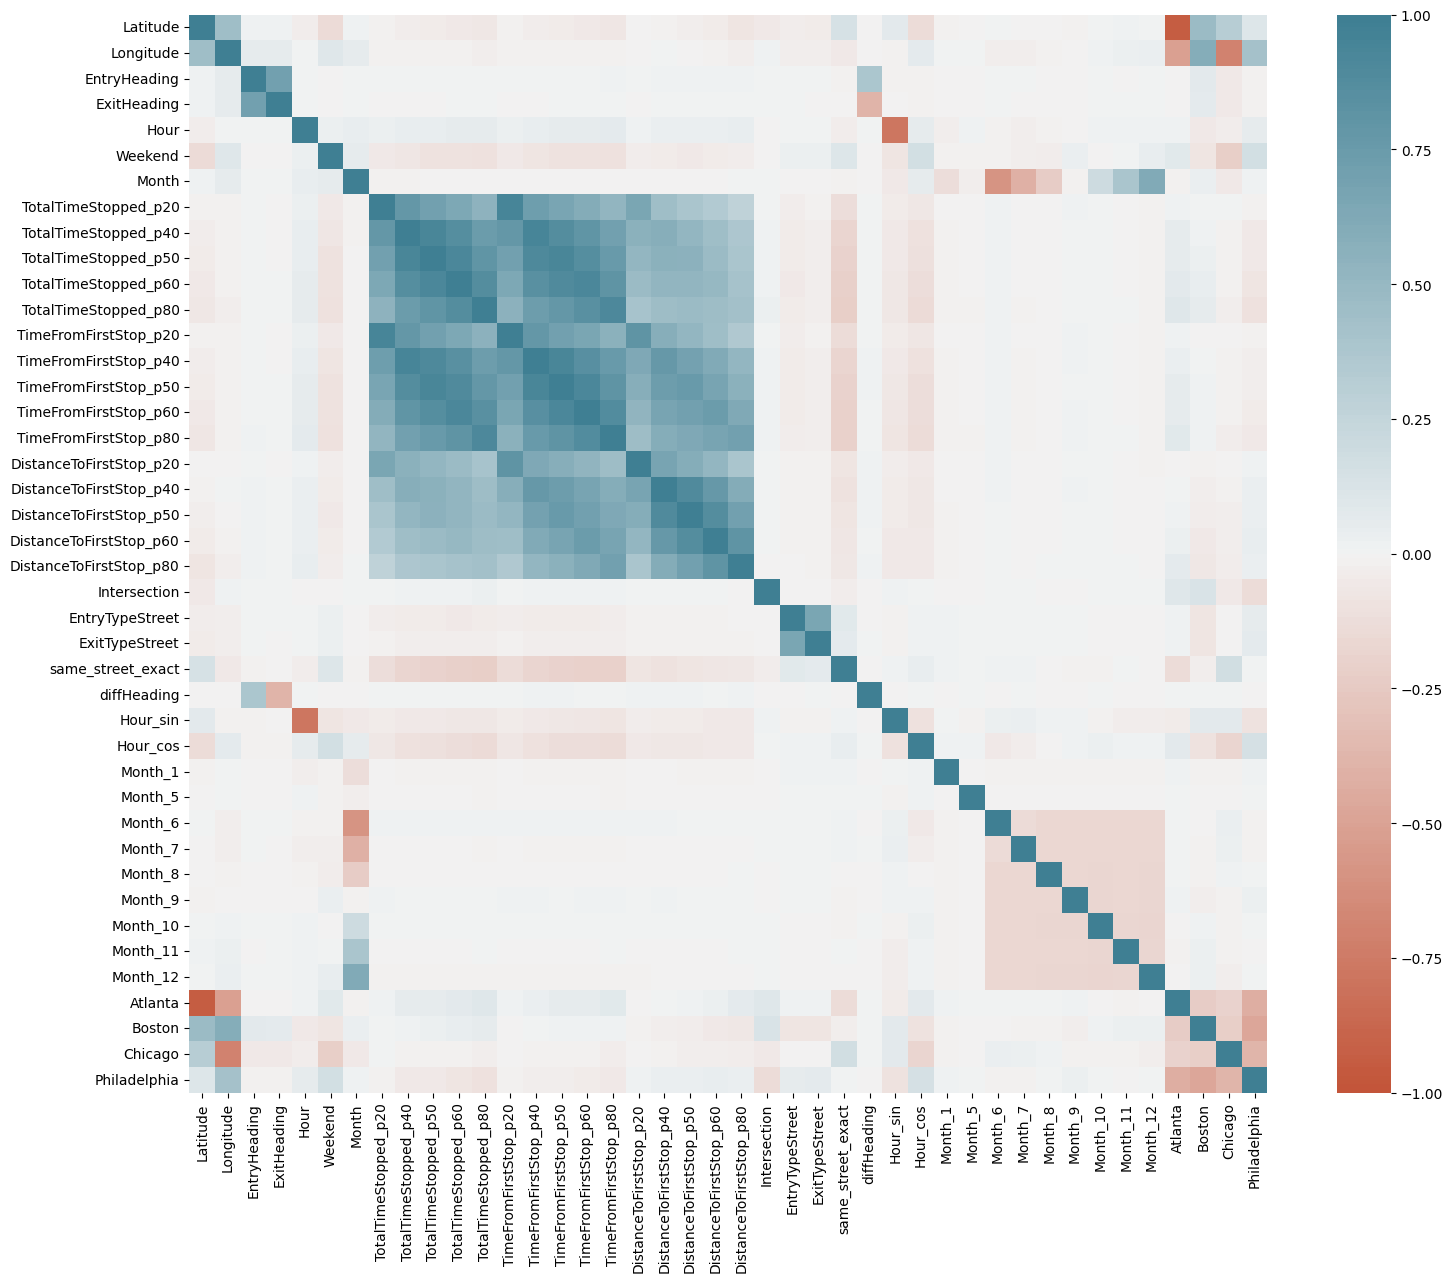

In [344]:
"""Let’s make a correlation matrix heatmap for the data set."""
plt.figure(figsize=(18,14))
sns.heatmap(train_df.corr(),vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

In [345]:
"""Let's look at our final train and test data for modelling."""
display(train_df.head(3))
display(test_df.head(3))

,Latitude,Longitude,EntryHeading,ExitHeading,Hour,Weekend,Month,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Atlanta,Boston,Chicago,Philadelphia
0,0.763743,-1.640545,1.0,1.0,13,0,10,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1,0.112743,0.463199,0.0,1.5,17,0,11,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
2,0.108623,0.448976,1.5,1.5,14,1,10,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,True


,Latitude,Longitude,EntryHeading,ExitHeading,Hour,Weekend,Month,Intersection,EntryTypeStreet,ExitTypeStreent,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Atlanta,Boston,Chicago,Philadelphia
0,0.117083,0.461277,1.5,0.00,0,0,6,4074,4,4,...,False,False,False,False,False,False,False,False,False,True
1,0.912974,1.153455,0.5,1.75,9,0,9,3061,2,2,...,False,False,True,False,False,False,False,True,False,False
2,-1.967198,-1.094935,0.5,0.50,18,0,6,3205,1,1,...,False,False,False,False,False,False,True,False,False,False


这一部分可有可无。主要是根据该列的数据类型和取值范围，尽可能将其转换为占用更少内存的类型。对于数值型数据（如整数和浮点数），会判断其最小值和最大值，选择合适的精度（如 int8、int16、float16、float32 等）；对于非数值型（如字符串或类别型），则直接转换为 pandas 的 category 类型，这样可以大幅压缩内存，尤其是高重复率的文本数据。可以避免内存溢出，并提升数据处理效率。

In [346]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 116.83 MB
Memory usage after optimization is: 37.19 MB
Decreased by 68.2%
Memory usage of dataframe is 11.92 MB
Memory usage after optimization is: 4.58 MB
Decreased by 61.6%


将训练集和测试集的数据分为特征（X）和目标变量（Y），为后续的建模做准备。

将我们要预测的值从训练集中删去，随后分别将6个目标变量单独赋值给 y1_train 到 y6_train，每个变量对应一个具体的预测目标

In [347]:
'''Seting X and Y'''
target_var = train_df.iloc[:, 7:22]
X_train = train_df.drop(target_var, axis = 1)

y1_train = train_df["TotalTimeStopped_p20"]
y2_train = train_df["TotalTimeStopped_p50"]
y3_train = train_df["TotalTimeStopped_p80"]
y4_train = train_df["DistanceToFirstStop_p20"]
y5_train = train_df["DistanceToFirstStop_p50"]
y6_train = train_df["DistanceToFirstStop_p80"]

X_test = test_df

In [348]:
"""Let's have a final look at our data"""
print('Input matrix dimension:', X_train.shape)
print('Output vector dimension:',y1_train.shape)
print('Test data dimension:', X_test.shape)

Input matrix dimension: (500000, 27)
Output vector dimension: (500000,)
Test data dimension: (100000, 27)


明确哪些是类别型特征

cat_feat 是 “categorical features”（类别特征）的缩写变量名

In [349]:
"""pecifying categorical features"""
cat_feat = ['Hour', 'Weekend','Month', 'same_street_exact', 'Intersection',
       'Atlanta', 'Boston', 'Chicago', 'Philadelphia', 'EntryTypeStreet', 'ExitTypeStreet']

In [350]:
all_preds ={0:[],1:[],2:[],3:[],4:[],5:[]}
all_target = [y1_train, y2_train, y3_train, y4_train, y5_train, y6_train]
print(all_target)

[0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
499995    0.0
499996    0.0
499997    0.0
499998    0.0
499999    0.0
Name: TotalTimeStopped_p20, Length: 500000, dtype: float16, 0          0.0
1          0.0
2          0.0
3         16.0
4          0.0
          ... 
499995     0.0
499996     0.0
499997     0.0
499998     0.0
499999     0.0
Name: TotalTimeStopped_p50, Length: 500000, dtype: float16, 0          0.0
1          0.0
2          0.0
3         25.0
4          0.0
          ... 
499995     0.0
499996     0.0
499997     0.0
499998    20.0
499999     0.0
Name: TotalTimeStopped_p80, Length: 500000, dtype: float16, 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
499995    0.0
499996    0.0
499997    0.0
499998    0.0
499999    0.0
Name: DistanceToFirstStop_p20, Length: 500000, dtype: float16, 0          0.0000
1          0.0000
2          0.0000
3         79.3125
4          0.0000
           ...   
499995    

d:\Anaconda\envs\rnn_env\lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


用 LightGBM 和交叉验证来评估一组超参数的效果，以便用于超参数优化

超参数是在训练模型之前人工设置的参数，而超参数优化就是寻找最合适的超参数组合，使模型效果最好（例如预测误差最小）。

> LightGBM（Light Gradient Boosting Machine）是微软开发的一个基于梯度提升（GBDT）的机器学习框架，用于分类、回归、排序等任务。

这里还用到了5折交叉验证

1. 把整个训练集划分为 5 份；
2. 每次用其中 1份作为验证集，其余4份作为训练集；
3. 一共训练 5 次，每次都更换验证集；
4. 得到 5 个评价指标（比如 5 个 RMSE），再取平均作为模型的综合性能。



In [351]:
# Reference: 
# https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-faster-speed

dtrain = lgb.Dataset(data=X_train, label=y1_train, categorical_feature=cat_feat)

'''Define objective function'''
def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, lambda_l1, lambda_l2):
      
        params = {'application':'regression',
                  'num_iterations': 400,
                  'learning_rate':0.01,
                  'metric':'rmse',
                  'num_threads': 8} # Default parameters
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        
        cv_results = lgb.cv(params, dtrain, nfold=3, seed=44, stratified=False)
        return -np.min(cv_results['valid rmse-mean'])

In [352]:
''' Define search space of hyperparameters'''
pds = {'num_leaves': (100, 230),
          'feature_fraction': (0.1, 0.5),
          'bagging_fraction': (0.8, 1),
          'lambda_l1': (0,3),
          'lambda_l2': (0,5),
          'max_depth': (8, 19),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (1, 20)
        }

In [353]:
'''Define a surrogate model of the objective function and call it.'''
optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=44)
                                  
# Optimize
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | num_le... | featur... | baggin... | lambda_l1 | lambda_l2 | max_depth | min_sp... | min_ch... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4710
[LightGBM] [Info] Number of data points in the train set: 333332, number of used features: 27
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

In [354]:
'''Best parameters after optimization'''
optimizer.max

{'target': np.float64(-6.156246562922516),
 'params': {'num_leaves': np.float64(158.34159889260383),
  'feature_fraction': np.float64(0.5),
  'bagging_fraction': np.float64(1.0),
  'lambda_l1': np.float64(0.0),
  'lambda_l2': np.float64(3.2634986736829124),
  'max_depth': np.float64(13.311213819606248),
  'min_split_gain': np.float64(0.001),
  'min_child_weight': np.float64(16.45195072180449)}}

In [355]:
p = optimizer.max['params']
param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2':p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learning_rate':0.05,
         'objective': 'regression',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'seed': 44,
         'metric': 'rmse'
        }
param

print(X_train.shape)

(500000, 27)


In [356]:
'''Instantiate the models with optimized hyperparameters.'''
print(X_train.shape)
train = X_train
test = X_test 

for i in range(len(all_preds)):
    print('Training and predicting for target {}'.format(i+1))
    print(train.shape, all_target[i].shape)
    X_train, X_test, y_train, y_test = train_test_split(train, all_target[i], test_size=0.2, random_state=31)
    xg_train = lgb.Dataset(X_train, label = y_train)
    xg_valid = lgb.Dataset(X_test, label = y_test)
    clf = lgb.train(param, xg_train, 10000, valid_sets = [xg_valid], callbacks=[early_stopping(stopping_rounds=200)])
    all_preds[i] = clf.predict(test, num_iteration=clf.best_iteration)

(500000, 27)
Training and predicting for target 1
(500000, 27) (500000,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 27
[LightGBM] [Info] Start training from score 1.754095
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3860]	valid_0's rmse: 5.82086
Training and predicting for target 2
(500000, 27) (500000,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 400000, number o

In [357]:
submission = pd.read_csv('submission_example.csv')
submission.head()

,id,TotalTimeStopped_p20,TotalTimeStopped_p50,TotalTimeStopped_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p50,DistanceToFirstStop_p80
0,500000,-0.431895,3.580245,39.858971,1.745218,-30.945662,192.498265
1,500001,4.402103,12.329614,23.813371,17.418827,85.319729,89.255058
2,500002,5.791710,6.911353,47.485334,1.885405,-22.462333,159.969292
3,500003,4.925284,1.459827,47.588069,13.811372,33.103121,-36.482734
4,500004,-4.421495,8.329746,3.706521,-5.428337,-28.696852,-14.209644


In [358]:
dt = pd.DataFrame(all_preds)
submission['TotalTimeStopped_p20'] = dt[0].values
submission['TotalTimeStopped_p50'] = dt[1].values
submission['TotalTimeStopped_p80'] = dt[2].values
submission['TotalTimeStopped_p20'] = dt[3].values
submission['TotalTimeStopped_p50'] = dt[4].values
submission['TotalTimeStopped_p80'] = dt[5].values

submission.head()

In [360]:
submission.to_csv('submission.csv', index=False)